##  Double descent in two layer neural network
From "Early stopping in deep neural networks: double descent and how to eliminate it."

In [255]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch

import sys
sys.path.append('../code/')
from linear_utils import linear_model, is_float, get_modulation_matrix
from train_utils import save_config, prune_data

In [371]:
class linear_model_s():
    def __init__(self, d, dy=1, sigma_noise=0, sigma=1.0, beta=None, scale_beta=False, kappa=1.0, p=None, transform_data=False, zero_eigs=0):
        self.d = d
        self.dy = dy
        
        if beta is None:
            self.beta = np.random.randn(self.d * self.dy).reshape(self.d, self.dy)
        else:
            self.beta = beta
            
            self.beta = self.beta.reshape(-1, self.dy)            
            assert self.beta.shape == (self.d, self.dy)
            
        self.sigma_noise = sigma_noise  
        self.sigma = sigma
        
        self.kappa = kappa
        self.p = p if p is not None else np.ceil((d - zero_eigs) / 2)

        
        self.transform_data = transform_data
        self.zero_eigs = zero_eigs
        self.transform_mat = None
        
                    
        if scale_beta:
            self.beta = np.linalg.inv(self.modulation_matrix()) @ self.beta 
            
            
    
    def sample(self, n, train=True): 
    
        if not self.transform_data:
            Xs = np.random.randn(n * self.d).reshape(n, self.d) * np.diag(self.modulation_matrix()).reshape(1, -1)
        else:
            
            Xs = np.random.randn(n * self.d).reshape(n, self.d) 
            
            if train:
                U, S, Vh = np.linalg.svd(Xs, full_matrices=True)
                self.left_singular_vecs = U
            
                if self.transform_data:
                    self.transform_mat = np.transpose(Vh) 
                                       
                    if n >= self.d:
                        S_inv = np.diag(1 / S)
                        F = self.modulation_matrix() 

                    else:
                        S_inv = np.diag(np.concatenate((1 / S, np.zeros((self.d - n,))), axis=-1))
                        F = np.diag(np.concatenate((np.diag(self.modulation_matrix()), np.zeros((self.d - n,))), axis=-1))
                   
           
                    self.transform_mat = np.transpose(Vh)@S_inv@F 
                    
            else:
                assert self.transform_mat is not None, "You need to sample training data first for transform to be possible"
                
            Xs = Xs @ self.transform_mat
            
        ys = Xs @ self.beta
        
        if train: 
            ys += self.sigma_noise*np.random.randn(n, self.dy)
        
        return Xs, ys
    
    def modulation_matrix(self):
    
        if self.zero_eigs > 0:
            return np.diag(get_modulation_matrix(self.d - self.zero_eigs, self.p, self.kappa, diag_sorted=True)[::-1])
        else:
            return np.diag(get_modulation_matrix(self.d, self.p, self.kappa, diag_sorted=True)[::-1])
        

In [380]:
np.random.seed(12)
d_out = 1      # dimension of y
d = 10
n = 20
n_test = 1000
kappa = np.sqrt(4 * n) 
p = 1

# sample training set 
lin_model = linear_model_s(d, sigma_noise=1.0, beta=np.ones(d,) * 1, scale_beta=True, kappa=kappa, p=p, transform_data=False)
Xs, ys = lin_model.sample(n)
Xs, ys = torch.Tensor(Xs), torch.Tensor(ys.reshape((-1,1)))

# sample test set
Xt, yt = lin_model.sample(n_test)
Xt, yt = torch.Tensor(Xt), torch.Tensor(yt.reshape((-1,1)))

V, S, _ = np.linalg.svd(Xs.T@Xs)

print(V)
print(S)

[[-0.04530712  0.51769817  0.42826292 -0.18069923  0.09165604 -0.48915872
  -0.35815912 -0.30054757  0.21809967 -0.00481846]
 [-0.12653075  0.5417945   0.21756649  0.3061904   0.41531685  0.24937597
   0.31118485  0.4640358   0.04916033 -0.01012529]
 [ 0.30604574 -0.16160084  0.4217784  -0.11207637  0.21577103  0.40900874
   0.37098223 -0.5373678   0.22086419 -0.02729003]
 [-0.01273223  0.49736667 -0.63024795  0.05146629  0.07490384  0.09909642
   0.15535857 -0.5267707  -0.181938    0.04946982]
 [-0.07535683  0.17549191  0.00479054 -0.17383717 -0.13934746  0.71325547
  -0.6274797   0.03851302  0.09456377 -0.03121297]
 [-0.28228316 -0.03334382  0.41047782  0.3117632  -0.11875351  0.07990465
  -0.07291931 -0.24292253 -0.75110465  0.06739558]
 [-0.17899276 -0.2304532  -0.09402522  0.75736785  0.17373969 -0.02903594
  -0.2747051  -0.23570064  0.40629965 -0.07266673]
 [ 0.15076227  0.26923332  0.12837736  0.2913108  -0.8297243   0.04103168
   0.24384938  0.00676405  0.23195341 -0.00217612]


In [381]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='mean')
risk_fn = loss_fn

In [382]:
def get_jacobian_two_layer(X, y, model, crit):
    
    grads = []
    for cx, cy in zip(X, y):

        cur_grads = []
        model.zero_grad()
        co = model(cx)
        co.backward(torch.ones(len(cy)))

        for p in model.parameters():
            if p.grad is not None and len(p.data.shape) > 1:
                cur_grads.append(p.grad.data.numpy().flatten())
                
        grads.append(np.concatenate(cur_grads))
    return np.array(grads)

## Linear model

In [398]:
# Two layer neural network in pytorch
scales = [0.001] * 2
lr = [0.001] * 2
hidden_dim = 100
its = 10000

model = torch.nn.Sequential(
        torch.nn.Linear(d, hidden_dim, bias=False),
        torch.nn.Identity(),
        torch.nn.Linear(hidden_dim, 1, bias=False),
    )
  

with torch.no_grad():
    i = 0
    for m in model:
        if type(m) == torch.nn.Linear:

            m.weight.data = torch.randn(m.weight.data.shape) * scales[i] #torch.ones(m.weight.data.shape) * scales[i]
            print(m.weight.data.shape, scales[i])
            
            if i == 0:
                W10 = m.weight.data.clone().T.numpy()

            i += 1

torch.Size([100, 10]) 0.001
torch.Size([1, 100]) 0.001


In [399]:
# compute the Jacobian at initialization (code taken from https://github.com/MLI-lab/early_ stopping_double_descent)
J = get_jacobian_two_layer(Xs, ys, model, loss_fn)
uv, sv, vtv = np.linalg.svd(J)

v1 = []
v2 = []
for i in range(sv.shape[0]):
    v1.append(np.linalg.norm(vtv[i,:][:np.prod([hidden_dim, d])]))
    v2.append(np.linalg.norm(vtv[i,:][-np.prod([1, hidden_dim]):]))
    
v1 = np.array(v1)
v2 = np.array(v2)
vTrec = np.linalg.norm(np.stack((v1, v2)), axis=0)


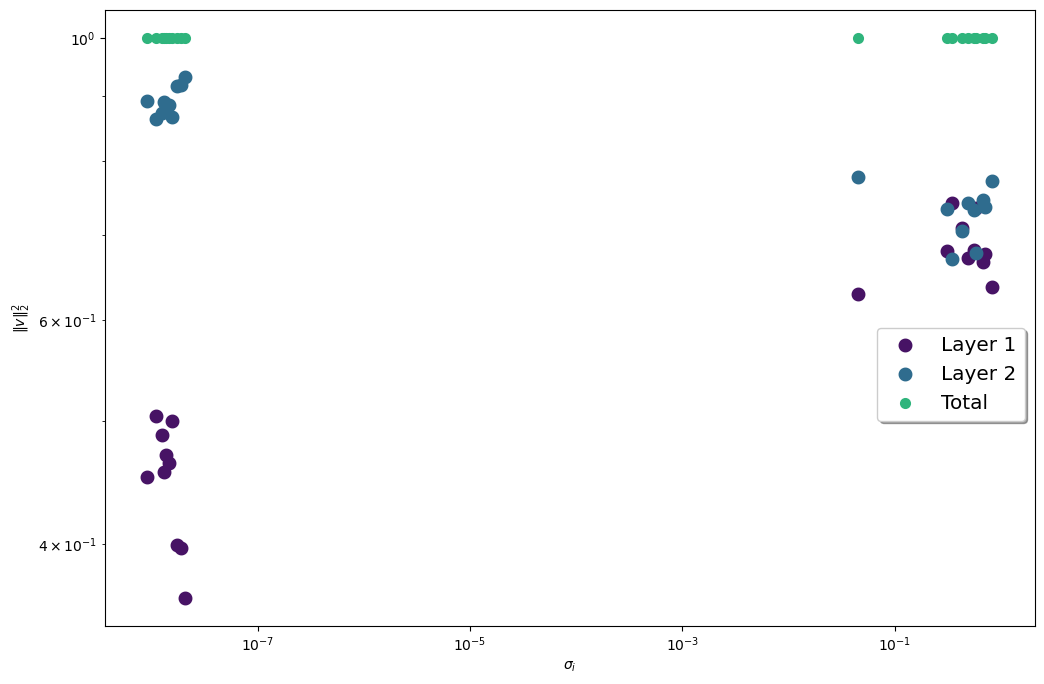

In [400]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(650/1000)]
labelList = ["Layer 1", "Layer 2", "Total"]

fig = plt.figure(figsize=(12,8))

ax = [plt.subplot(111)]

ax[0].scatter(sv, v1, 
            color=colorList[0], 
            label=labelList[0],
            lw=4)
ax[0].scatter(sv, v2, 
            color=colorList[1], 
            label=labelList[1],
#                 ls='dashed',
            lw=4)
ax[0].scatter(sv, vTrec, 
            color=colorList[2], 
            label=labelList[2],
#                 ls='dashed',
            lw=2)
    
ax[-1].legend(loc=0, bbox_to_anchor=(1, 0.5), fontsize='x-large',
                   frameon=True, fancybox=True, shadow=True, ncol=1)
ax[0].set_ylabel(r'$\Vert v \Vert_2^2$')

# for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
#                                               r';$v = $' + str(weights[i]['v']))
for axis in ax: 
    axis.set_xlabel(r'$\sigma_i$')
    axis.set_xscale('log')
    axis.set_yscale('log')

plt.show()

In [401]:
losses_lin = []
risks_lin = []
weights_lin = []

print_freq = 1000
for t in range(int(its)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses_lin.append(loss.item())

    if not t % print_freq:
        print(t, loss.item())
        
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_lin.append(risk.item())

        if not t % print_freq:
            print(t, risk.item())
        
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        
        w = None
        for param in model.parameters():
            
            if len(param.shape) > 1:
                if i == 0:
                    w = param.data.T.clone().detach()
                else:
                    w = w @ param.data.T.clone().detach()
                    
                param.data -= lr[i] * param.grad            
                i += 1
                
        weights_lin.append(w.numpy().squeeze())
            

0 12.327120780944824
0 10.587078094482422
1000 0.6128435134887695
1000 3.068697690963745
2000 0.4277659058570862
2000 2.124758005142212
3000 0.4016647934913635
3000 1.9640556573867798
4000 0.4006100296974182
4000 1.951056957244873
5000 0.4005811810493469
5000 1.9495779275894165
6000 0.40058040618896484
6000 1.9493601322174072
7000 0.40058040618896484
7000 1.9493260383605957
8000 0.40058034658432007
8000 1.9493253231048584
9000 0.40058040618896484
9000 1.9493250846862793


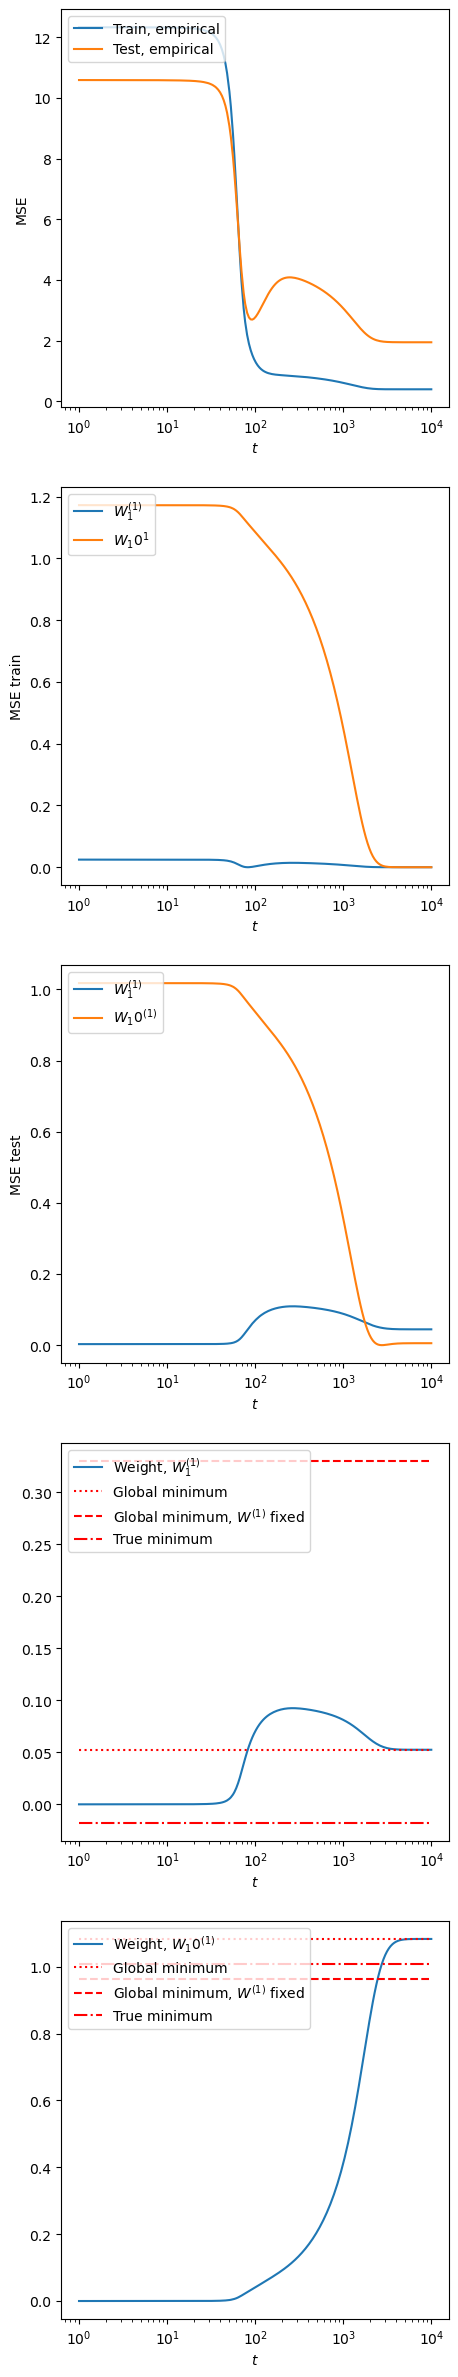

[[-0.01802858]
 [ 0.26134392]
 [ 0.09942854]
 [-0.00346876]
 [-0.03002858]
 [-0.01077526]
 [-0.03974126]
 [ 0.05747747]
 [-0.10182585]
 [ 1.00881462]]


In [402]:
losses = np.array(losses_lin)
risks = np.array(risks_lin)

w_min = (ys.T @ Xs @ np.linalg.inv(Xs.T@Xs)).numpy().squeeze()

V, _, _ = np.linalg.svd(Xs.T@Xs)

losses_w = np.array([(V @ w_min  - V @ w)**2 for w in weights_lin])
risks_w = np.array([(V @ lin_model.beta.squeeze() - V @ w)**2 for w in weights_lin])
ws = np.array([V @ w for w in weights_lin])

res = 200
t_range = [int(i) for i in np.geomspace(1, len(risks)-1, num=res)]

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig, ax = plt.subplots(5, 1, figsize=(5, 30)) #plt.subplots(1, 5, figsize=(30, 5))

# Plot MSE
ax[0].plot(t_range, losses[t_range], label="Train, empirical")
ax[0].plot(t_range, risks[t_range], label="Test, empirical")

ex = 1
ax[1].plot(t_range, losses_w[t_range, ex - 1] * kappa, label=fr"$W_{ex}^{{(1)}}$")
ax[1].plot(t_range, losses_w[t_range, -1], label=fr"$W_{d}^{(1)}$")

ax[2].plot(t_range, risks_w[t_range, ex - 1] * kappa, label=fr"$W_{ex}^{{(1)}}$")
ax[2].plot(t_range, risks_w[t_range, -1], label=fr"$W_{d}^{{(1)}}$")

#ax[3].plot(geo_samples, (losses_w[t_range, :-1].sum(axis=-1) * kappa + losses_w[geo_samples, -1]), label="Train")
#ax[3].plot(geo_samples, (risks_w[t_range, :-1].sum(axis=-1) * kappa + losses_w[geo_samples, -1]), label="Test")

# Plot trajectories
ax[3].plot(t_range, ws[t_range, ex - 1], label=fr"Weight, $W_{ex}^{{(1)}}$")
ax[4].plot(t_range, ws[t_range, -1], label=fr"Weight, $W_{d}^{{(1)}}$")

# Add fixed points (first layer fixed)
Zs = Xs.numpy() @ W10
Z2_opt = np.linalg.inv(Zs.T @ Zs) @ Zs.T @ ys.numpy()
Z_opt_2 = W10 @ Z2_opt

w_true_ex = [(V @ lin_model.beta)[ex - 1], (V @ lin_model.beta)[-1]]
Z_opt_2_ex = [(V @ Z_opt_2)[ex - 1], (V @ Z_opt_2)[-1]]
w_min_ex = [(V @ w_min)[ex - 1], (V @ w_min)[-1]]
for i in range(2):
    ax[3 + i].hlines(w_min_ex[i], min(t_range), max(t_range), color = 'r', linestyles='dotted', label=r"Global minimum")
    ax[3 + i].hlines(Z_opt_2_ex[i], min(t_range), max(t_range), color = 'r', linestyles='dashed', label=r"Global minimum, $W^{(1)}$ fixed")
    ax[3 + i].hlines(w_true_ex[i], min(t_range), max(t_range), color = 'r', linestyles='dashdot', label=r"True minimum")
    
    ax[3 + i].legend(loc=2)
    

ylabs = ["MSE", "MSE train", "MSE test", "", ""]
for i in range(ax.shape[0]):
    ax[i].set_xscale('log')
    ax[i].set_xlabel('t')
    ax[i].set_ylabel(ylabs[i])

    if i < 3:
        ax[i].legend(loc=2)
    
    ax[i].set_xlabel(r'$t$')

plt.show()

# OBS: notera att vi inte såg detta mönster riktigt i alla dims

print(V@lin_model.beta)

# ReLU-model

In [403]:
# Two layer neural network in pytorch
its = 200000
lr = [0.0001] * 2

model = torch.nn.Sequential(
        torch.nn.Linear(d, hidden_dim, bias=False),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1, bias=False),
    )
  

with torch.no_grad():
    i = 0
    for m in model:
        if type(m) == torch.nn.Linear:

            m.weight.data = torch.ones(m.weight.data.shape) * scales[i]
            print(m.weight.data.shape, scales[i])

            i += 1

torch.Size([100, 10]) 0.001
torch.Size([1, 100]) 0.001


In [404]:
# compute the Jacobian at initialization
J = get_jacobian_two_layer(Xs, ys, model, loss_fn)
uv, sv, vtv = np.linalg.svd(J)

v1 = []
v2 = []
for i in range(sv.shape[0]):
    v1.append(np.linalg.norm(vtv[i,:][:np.prod([250, 50])]))
    v2.append(np.linalg.norm(vtv[i,:][-np.prod([1, 250]):]))
v1 = np.array(v1)
v2 = np.array(v2)
vTrec = np.linalg.norm(np.stack((v1, v2)), axis=0)


AttributeError: 'list' object has no attribute 'set_xlabel'

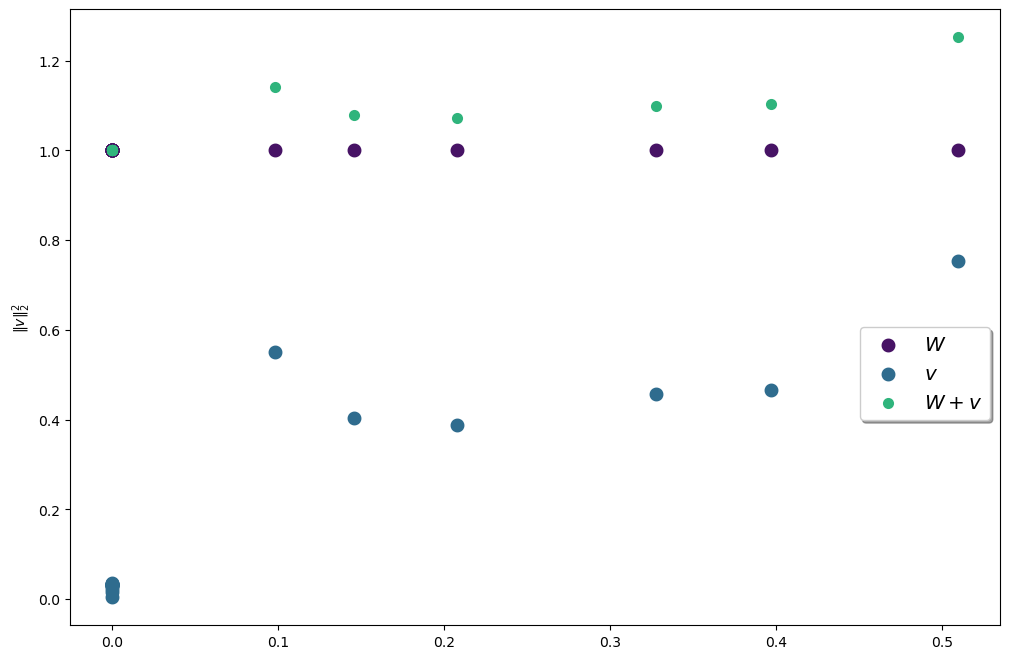

In [405]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(650/1000)]
labelList = [r'$W$', r'$v$', r'$W + v$']

fig = plt.figure(figsize=(12,8))

ax = [plt.subplot(111)]

ax[0].scatter(sv, v1, 
            color=colorList[0], 
            label=labelList[0],
            lw=4)
ax[0].scatter(sv, v2, 
            color=colorList[1], 
            label=labelList[1],
#                 ls='dashed',
            lw=4)
ax[0].scatter(sv, vTrec, 
            color=colorList[2], 
            label=labelList[2],
#                 ls='dashed',
            lw=2)
    
ax[-1].legend(loc=0, bbox_to_anchor=(1, 0.5), fontsize='x-large',
                   frameon=True, fancybox=True, shadow=True, ncol=1)
ax[0].set_ylabel(r'$\Vert v \Vert_2^2$')

# for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
#                                               r';$v = $' + str(weights[i]['v']))
for axis in ax: 
    ax.set_xlabel(r'$\sigma_i$')
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.show()

In [406]:
losses_nonlin = []
risks_nonlin = []
weights_nonlin = []

print_freq = 1000
for t in range(int(its)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses_nonlin.append(loss.item())

    if not t % print_freq:
        print(t, loss.item())
        
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_nonlin.append(risk.item())

        if not t % print_freq:
            print(t, risk.item())
        
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        
        w = []
        for param in model.parameters():
            w.append(param.data.T.clone().numpy().reshape(-1))

            if len(param.shape) > 1:
                param.data -= lr[i] * param.grad            

        weights_nonlin.append(np.concatenate(w))

                
            

0 12.326981544494629
0 10.579632759094238
1000 12.323785781860352
1000 10.569427490234375
2000 12.3041353225708
2000 10.533754348754883
3000 12.218398094177246
3000 10.396893501281738
4000 12.067169189453125
4000 10.077824592590332
5000 11.983299255371094
5000 9.74264144897461
6000 11.95157527923584
6000 9.50171947479248
7000 11.934871673583984
7000 9.315183639526367
8000 11.922820091247559
8000 9.161986351013184
9000 11.912712097167969
9000 9.016522407531738
10000 11.903627395629883
10000 8.876185417175293
11000 11.8950777053833
11000 8.735051155090332
12000 11.886716842651367
12000 8.5928373336792
13000 11.878299713134766
13000 8.453764915466309
14000 11.869698524475098
14000 8.320015907287598
15000 11.862897872924805
15000 8.177607536315918
16000 11.857694625854492
16000 8.048771858215332
17000 11.853718757629395
17000 7.935094833374023
18000 11.850679397583008
18000 7.836605072021484
19000 11.848297119140625
19000 7.750415802001953
20000 11.846390724182129
20000 7.6752400398254395


166000 11.814291000366211
166000 6.8019256591796875
167000 11.81429386138916
167000 6.800549030303955
168000 11.814201354980469
168000 6.798782825469971
169000 11.814072608947754
169000 6.79742956161499
170000 11.814043998718262
170000 6.795865058898926
171000 11.813966751098633
171000 6.795107364654541
172000 11.813867568969727
172000 6.793337821960449
173000 11.81378173828125
173000 6.791855335235596
174000 11.813679695129395
174000 6.79061222076416
175000 11.81357479095459
175000 6.788936614990234
176000 11.81360912322998
176000 6.788197040557861
177000 11.813455581665039
177000 6.786347389221191
178000 11.813348770141602
178000 6.7848992347717285
179000 11.813310623168945
179000 6.783133029937744
180000 11.813209533691406
180000 6.781895160675049
181000 11.813066482543945
181000 6.780755996704102
182000 11.81299877166748
182000 6.7791748046875
183000 11.812973022460938
183000 6.778073310852051
184000 11.812884330749512
184000 6.776662826538086
185000 11.812742233276367
185000 6.775

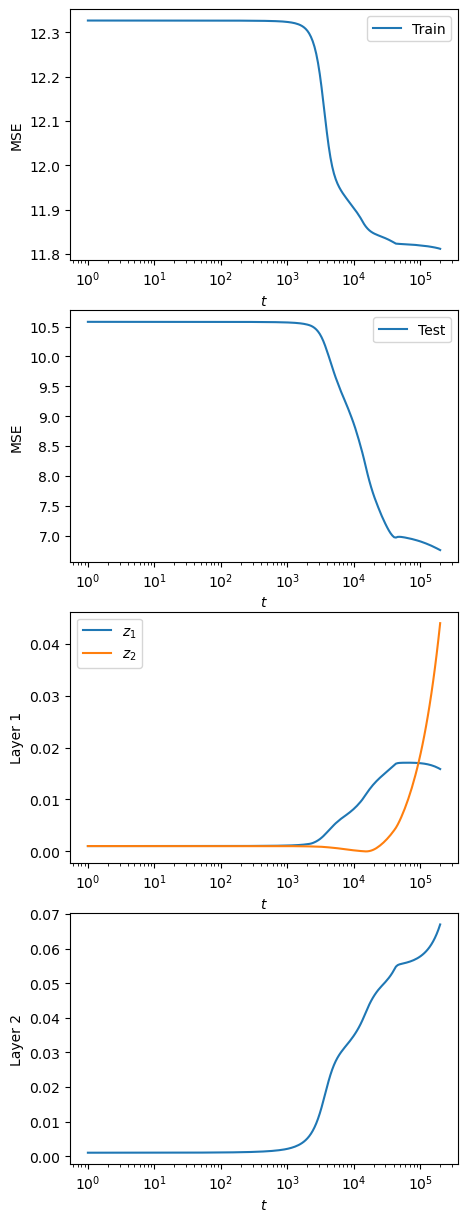

In [407]:
losses = np.array(losses_nonlin)
risks = np.array(risks_nonlin)
ws = np.array(weights_nonlin)

geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=200)]

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig, ax = plt.subplots(4, 1, figsize=(5, 15))

ax[0].plot(geo_samples, losses[geo_samples], label="Train")
ax[1].plot(geo_samples, risks[geo_samples], label="Test")

ws_lay_1, ws_lay_2 = ws[:, :(d * hidden_dim)], ws[:, (d * hidden_dim):]
ax[2].plot(geo_samples, ws_lay_1[geo_samples, :((d-1) * hidden_dim)].mean(axis=-1), label=fr"$z_1$")
ax[2].plot(geo_samples, ws_lay_1[geo_samples, ((d-1) * hidden_dim):(d * hidden_dim)].mean(axis=-1), label=fr"$z_2$")
ax[3].plot(geo_samples, ws_lay_2[geo_samples, :].mean(axis=-1))


for i in range(4):
    ax[i].set_xscale('log')
    
    if i < 2:
        ax[i].legend()
        ax[i].set_ylabel('MSE')
        
    ax[i].set_xlabel(r'$t$')
    
ax[2].legend()
ax[2].set_ylabel('Layer 1')
ax[3].set_ylabel('Layer 2')

plt.show()